# Welcome to our demonstration notebook for EO diffusion models!

## Import Libraries

In [2]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms 
from torchvision.utils import save_image, make_grid
import torchvision.transforms.functional as F
from torchmetrics.functional import structural_similarity_index_measure
from torchmetrics.functional import peak_signal_noise_ratio
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from diffusion.model import EODiffusion
from utils import *
import os
import math
import argparse
from data import *
from pytorch_lightning.loggers import WandbLogger
from PIL import Image
from backbones.unet_openai import UNetModel
from diffusion.ddim import DDIMSampler
#from inference import parse_args

c:\Users\philab\anaconda3\envs\fulvio_diffusers\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utils

In [3]:
def parse_args(def_arg=False):
    parser = argparse.ArgumentParser(description="Training MNISTDiffusion")
    parser.add_argument('--lr',type = float ,default=0.001) # default 0.001
    parser.add_argument('--batch_size',type = int ,default=1)    
    parser.add_argument('--sampler_steps',type = int ,default=250) 
    parser.add_argument('--outdir',type = str,help = 'directory',default='data\clouds')
    parser.add_argument('--ckpt',type = str,help = 'define checkpoint path',default='results\\clouds_best.pt')
    parser.add_argument('--model_base_dim',type = int,help = 'base dim of Unet',default=64)
    parser.add_argument('--timesteps',type = int,help = 'sampling steps of DDPM',default=1000)
    parser.add_argument('--model_ema_steps',type = int,help = 'ema model evaluation interval',default=10)
    parser.add_argument('--model_ema_decay',type = float,help = 'ema model decay',default=0.995)
    parser.add_argument('--log_freq',type = int,help = 'training log message printing frequence',default=10)
    parser.add_argument('--no_clip',action='store_true',help = 'set to normal sampling method without clip x_0 which could yield unstable samples')
    parser.add_argument('--cpu',action='store_true',help = 'cpu training')
    parser.add_argument('--metrics',action='store_true',help = 'cpu training')
    parser.add_argument('--save',action='store_true',help = 'cpu training') # no need it, if save_dir is None then do not save
    parser.add_argument('--random_label',action='store_true',help = 'random label')
    parser.add_argument('--wandb',action='store_true',help = 'wandb logger usage')
    parser.add_argument('--num_classes',type = int,help = 'conditional training',default=0)
    parser.add_argument('--cond_type',type = str,help = 'cond type',default="sum")
    parser.add_argument('--sampler',type = str,help = 'sampler',default="ddpm")
    parser.add_argument('--samples_fid',action='store_true',help = 'cpu training')
    parser.add_argument('--n_iter',type = int,help = 'sampler',default=None)

    args = parser.parse_args() if not def_arg else parser.parse_args("")
    #ckpt_path = os.path.splitext(os.path.split(args.ckpt)[-1])[0]
    # n_samples substitute with batch_size, or delete n_iter

    return args

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

## Instantiate the model

In [4]:
# change this line to point to your actual folder
%cd D:\Fulvio\simplediff
args = parse_args(def_arg=True)

d:\Fulvio\simplediff


In [5]:
to_pil = transforms.ToPILImage()
to_tensor = transforms.ToTensor()
device="cpu" if args.cpu else "cuda:0"
torch.cuda.device(device)
ngpu = torch.cuda.device_count()
image_size = 64
in_ch,cond_channels,out_ch=3,0,3
base_dim, dim_mults, attention_resolutions,num_res_blocks, num_heads=128,[1,2,3,4],[4,8],2,8
num_classes = args.num_classes if args.num_classes > 0 else None
unet = UNetModel(image_size, in_channels=in_ch+cond_channels, model_channels=base_dim, out_channels=out_ch, channel_mult=dim_mults, 
                attention_resolutions=attention_resolutions,num_res_blocks=num_res_blocks, num_heads=num_heads, num_classes=num_classes)
model=EODiffusion(unet,
            timesteps=args.timesteps,
            image_size=image_size,
            in_channels=in_ch,
            cond_type = args.cond_type,
            device = device,
            ).to(device)
sampler = DDIMSampler(model)
trainable_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print(f"Diffusion with {trainable_params/1e06} M params")
#plot_params(sampler)

if args.ckpt:
    print("loading checkpoint...")
    ckpt=torch.load(args.ckpt)
    for key in list(ckpt.keys()):
        if 'model.' in key:
            ckpt[key.replace('model.', '')] = ckpt[key]
            del ckpt[key]
    model.load_state_dict(ckpt["model"])
    print("loaded!")

loading model...
Loaded!!
Diffusion with 88.220934 M params
loading checkpoint...
loaded!


## Inference

In this section, you can run the inference loop we provide you. The end result shows a grid with the following sequence:
<br>
cloudy image + mask - cloud removed - cloudy image

### Inference on some test images

They are stored in "data/clouds" folder. We use a checkpoint stored in "results" trained on Sentinel-2 Cloud Mask Catalogue https://zenodo.org/record/4172871

start inference


Sampling: 100%|██████████| 1000/1000 [00:39<00:00, 25.09it/s]



torch.Size([1, 3, 64, 64]) torch.Size([1, 3, 64, 64]) torch.Size([1, 3, 64, 64])
metrics:  0.0 0.0


Sampling:  23%|██▎       | 230/1000 [00:08<00:29, 26.45it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000292199455A0>
Traceback (most recent call last):
  File "c:\Users\philab\anaconda3\envs\fulvio_diffusers\lib\site-packages\torch\utils\data\dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "c:\Users\philab\anaconda3\envs\fulvio_diffusers\lib\site-packages\torch\utils\data\dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "c:\Users\philab\anaconda3\envs\fulvio_diffusers\lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "c:\Users\philab\anaconda3\envs\fulvio_diffusers\lib\multiprocessing\popen_spawn_win32.py", line 108, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
KeyboardInterrupt: 


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\philab\AppData\Local\Temp\ipykernel_27864\3419506181.py:30 in <module>                  │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\philab\\AppData\\Local\\Temp\\ipykernel_27864\\3419506181.py'                        │
│                                                                                                  │
│ c:\Users\philab\anaconda3\envs\fulvio_diffusers\lib\site-packages\torch\autograd\grad_mode.py:27 │
│ in decorate_context                                                                              │
│                                                                                                  │
│    24 │   │   @functools.wraps(func)                                                             │
│    25 │   │   def decorate_context(*args, **kwargs):                                             │
│    26 │   │   │   with self.clone():                                                             │
│ ❱  27 │   │   │   │   return func(*args, **kwargs)                                               │
│    28 │   │   return cast(F, decorate_context)                                                   │
│    29 │                                                                                          │
│    30 │   def _wrap_generator(self, func):                                                       │
│                                                                                                  │
│ d:\Fulvio\simplediff\diffusion\model.py:69 in sampling                                           │
│                                                                                                  │
│    66 │   │   │   │   │   save_image(gt_noised, f"results/prova/s{i}_gt.png") #save_image((1-m   │
│    67 │   │   │                                                                                  │
│    68 │   │   │   if clipped_reverse_diffusion:                                                  │
│ ❱  69 │   │   │   │   x_t=self._reverse_diffusion_with_clip(x_t,t,noise,cond=cond, y=y)          │
│    70 │   │   │   else:                                                                          │
│    71 │   │   │   │   x_t=self._reverse_diffusion(x_t,t,noise,cond=cond, y=y)                    │
│    72                                                                                            │
│                                                                                                  │
│ c:\Users\philab\anaconda3\envs\fulvio_diffusers\lib\site-packages\torch\autograd\grad_mode.py:27 │
│ in decorate_context                                                                              │
│                                                                                                  │
│    24 │   │   @functools.wraps(func)                                                             │
│    25 │   │   def decorate_context(*args, **kwargs):                                             │
│    26 │   │   │   with self.clone():                                                             │
│ ❱  27 │   │   │   │   return func(*args, **kwargs)                                               │
│    28 │   │   return cast(F, decorate_context)                                                   │
│    29 │                                                                                          │
│    30 │   def _wrap_generator(self, func):                                                       │
│                                                                                                  │
│ d:\Fulvio\simplediff\diffusion\model.py:132 in _reverse_diffusion_with_clip                      │
│                                                            

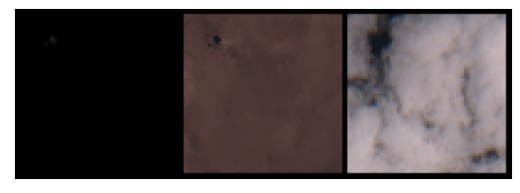

In [13]:
folder=args.outdir
dir_samples_fid, dir_samples  = os.path.join(folder,"samples_fid"), os.path.join(folder,"samples")
os.makedirs(folder,exist_ok=True), os.makedirs(dir_samples_fid,exist_ok=True), os.makedirs(dir_samples,exist_ok=True)
offset = len(os.listdir(dir_samples)) if args.cond_type is None else len(os.listdir(dir_samples))//3
print("start inference")
ssim, psnr, n  = 0, 0, 0
catg = "sample"
images, masks = glob.glob("data/clouds/*gt*"), glob.glob("data/clouds/*cond*")
len(images)
for j,(imfile,maskfile) in enumerate(zip(images,masks)):
    image, mask = to_tensor(Image.open(imfile))[None], to_tensor(Image.open(maskfile).convert("L"))[None] if args.cond_type is not None else None  # data[input_key], data[cond_key]
    idx = j + offset
    gt_path, cond_path, img_path = os.path.join(dir_samples, f"sample_{idx}_gt.png"), \
    os.path.join(dir_samples, f"sample_{idx}_cond.png"), \
    os.path.join(dir_samples, f"sample_{idx}.png") # check samples in [-1,1]

    if args.cond_type == "sum": mask = 1-mask
    if mask is not None:
        if mask.mean()>=0.9 or mask.mean()<=0.1: pass
    if args.cond_type is not None: 
        mask = mask.to(device)
        cond = mask
    
    image = image.to(device) # cond as a vocabulary with mask too? class_label, mask, image, text
    if args.cond_type == "sum": cond = torch.cat((image,cond),dim=1)

    model.eval()
    # put mask inside sampler, from outside only a cond input
    if args.sampler=="ddpm": 
        samples=model.sampling(args.batch_size,clipped_reverse_diffusion=not args.no_clip,device=device, 
    cond=cond, y=None, idx=0, save=True) 
    else: 
        samples,_ = sampler.sample(S=args.sampler_steps, batch_size=args.batch_size, mask=mask,
                shape=(out_ch, image_size, image_size), conditioning=None, verbose=False)
    
    samples = samples.clip(0,1) if image.min()>=0 else (samples+1.)/2. #samples = (samples+1.)/2. only if train data is in (-1,1)
    
    if cond is not None:
        if mask is not None: 
            #cond = image*((mask+0.7).clip(0,1))
            cond = image*mask
        (gt,cond) = (image, cond) if image.min()>=0 else ( (image+1.)/2., (cond+1.)/2. )
        if args.metrics:
            s, p = structural_similarity_index_measure(samples, gt, data_range=1.0), peak_signal_noise_ratio(samples, gt, data_range=1.0)
            ssim, psnr = ssim + s, psnr + p

        gt = F.adjust_brightness(gt, 3) if gt.mean()<0.2 else gt
        cond = F.adjust_brightness(cond, 3) if cond.mean()<0.2 and args.cond_type!="sum" else cond
        #if args.save: save_image(gt, gt_path, nrow=int(math.sqrt(args.batch_size)))
        #if args.save: save_image(cond, cond_path, nrow=int(math.sqrt(args.batch_size)))
        
    if args.samples_fid:
        for i in range(samples.shape[0]):
            samples_path = os.path.join(dir_samples_fid, f"{catg}_{idx}-{i}.png") # check samples in [-1,1]
            save_image(samples[i],samples_path)

    samples = F.adjust_brightness(samples, 3) if samples.mean()<0.2 and samples.shape[0]==1 else samples
    save_image(samples,img_path,nrow=int(math.sqrt(args.batch_size))) if args.save else print()

    for i in range(samples.shape[0]):
      grid = make_grid([cond[i], samples[i], gt[i]]) # careful, new, does not work with batch_size>1
      show(grid)
    n = n+1
    
    ssim_avg, psnr_avg = ssim/n, psnr/n # correct if len is referred to num batches
    print("metrics: ",ssim_avg, psnr_avg)
    if args.metrics:
        with open(os.path.join(dir, "metrics.txt"), "w") as f:
            f.write(f"ssim: {ssim_avg}")
            f.write(f"psnr: {psnr_avg}")
            f.write(f"length: {n}")

    if args.n_iter is not None:
        if j > args.n_iter: break

### Inference on all the data

In [ ]:
train_dataloader,test_dataloader=create_cloud_dataloaders(batch_size=args.batch_size, num_workers=4, size=image_size,
                ratio=0.5, length=-1, num_patches=2000, percents=[10,10,70])
folder=args.outdir
dir_samples_fid, dir_samples  = os.path.join(folder,"samples_fid"), os.path.join(folder,"samples")
os.makedirs(folder,exist_ok=True), os.makedirs(dir_samples_fid,exist_ok=True), os.makedirs(dir_samples,exist_ok=True)
offset = len(os.listdir(dir_samples)) if args.cond_type is None else len(os.listdir(dir_samples))//3
print("start inference")
ssim, psnr, n  = 0, 0, 0
catg = "sample"
for j,(data) in enumerate(test_dataloader):
    image, mask = data["image"], data["segmentation"] if args.cond_type is not None else None  # data[input_key], data[cond_key]
    idx = j + offset
    gt_path, cond_path, img_path = os.path.join(dir_samples, f"sample_{idx}_gt.png"), \
    os.path.join(dir_samples, f"sample_{idx}_cond.png"), \
    os.path.join(dir_samples, f"sample_{idx}.png") # check samples in [-1,1]

    if args.cond_type == "sum": mask = 1-mask
    if mask is not None:
        if mask.mean()>=0.9 or mask.mean()<=0.1: pass
    if args.cond_type is not None: 
        mask = mask.to(device)
        cond = mask
    
    image = image.to(device) # cond as a vocabulary with mask too? class_label, mask, image, text
    if args.cond_type == "sum": cond = torch.cat((image,cond),dim=1)

    model.eval()
    # put mask inside sampler, from outside only a cond input
    if args.sampler=="ddpm": 
        samples=model.sampling(args.batch_size,clipped_reverse_diffusion=not args.no_clip,device=device, 
    cond=cond, y=None, idx=0, save=True) 
    else: 
        samples,_ = sampler.sample(S=args.sampler_steps, batch_size=args.batch_size, mask=mask,
                shape=(out_ch, image_size, image_size), conditioning=None, verbose=False)
    
    samples = samples.clip(0,1) if image.min()>=0 else (samples+1.)/2. #samples = (samples+1.)/2. only if train data is in (-1,1)
    
    if cond is not None:
        if mask is not None: 
            #cond = image*((mask+0.7).clip(0,1))
            cond = image*mask
        (gt,cond) = (image, cond) if image.min()>=0 else ( (image+1.)/2., (cond+1.)/2. )
        if args.metrics:
            s, p = structural_similarity_index_measure(samples, gt, data_range=1.0), peak_signal_noise_ratio(samples, gt, data_range=1.0)
            ssim, psnr = ssim + s, psnr + p

        gt = F.adjust_brightness(gt, 3) if gt.mean()<0.2 else gt
        cond = F.adjust_brightness(cond, 3) if cond.mean()<0.2 and args.cond_type!="sum" else cond
        #if args.save: save_image(gt, gt_path, nrow=int(math.sqrt(args.batch_size)))
        #if args.save: save_image(cond, cond_path, nrow=int(math.sqrt(args.batch_size)))
        
    if args.samples_fid:
        for i in range(samples.shape[0]):
            samples_path = os.path.join(dir_samples_fid, f"{catg}_{idx}-{i}.png") # check samples in [-1,1]
            save_image(samples[i],samples_path)

    samples = F.adjust_brightness(samples, 3) if samples.mean()<0.2 and samples.shape[0]==1 else samples
    save_image(samples,img_path,nrow=int(math.sqrt(args.batch_size))) if args.save else print()
    print(gt.shape, samples.shape, cond.shape)

    for i in range(samples.shape[0]):
      grid = make_grid([cond[i], samples[i], gt[i]]) # careful, new, does not work with batch_size>1
      show(grid)
    n = n+1
    
    ssim_avg, psnr_avg = ssim/n, psnr/n # correct if len is referred to num batches
    print("metrics: ",ssim_avg, psnr_avg)
    if args.metrics:
        with open(os.path.join(dir, "metrics.txt"), "w") as f:
            f.write(f"ssim: {ssim_avg}")
            f.write(f"psnr: {psnr_avg}")
            f.write(f"length: {n}")

    if args.n_iter is not None:
        if j > args.n_iter: break

        
